# 3D Water Simulation

A computational essay by Maiken Kristiansen Revheim

## Introduction


Water is made of polar molecules. The hydrogen atoms form polar covalent bonds with the oxygen atom. Even though a water molecule has no net charge the polarity of water creates a small positive charge on the hydrogen atoms and a small negative charge on the oxygen atom. This is caused by oxygen being more electronegative than hydrogen. Electronegativity is an atoms ability to attract electrons. Thus the shared electron in the covalent bond is more likely to be found near the oxygen nucleus than the hydrogen, and because of the nonlinearity of the molecule it creates a partial negative charge near the oxygen and partial positive charge near both hydrogen atoms.

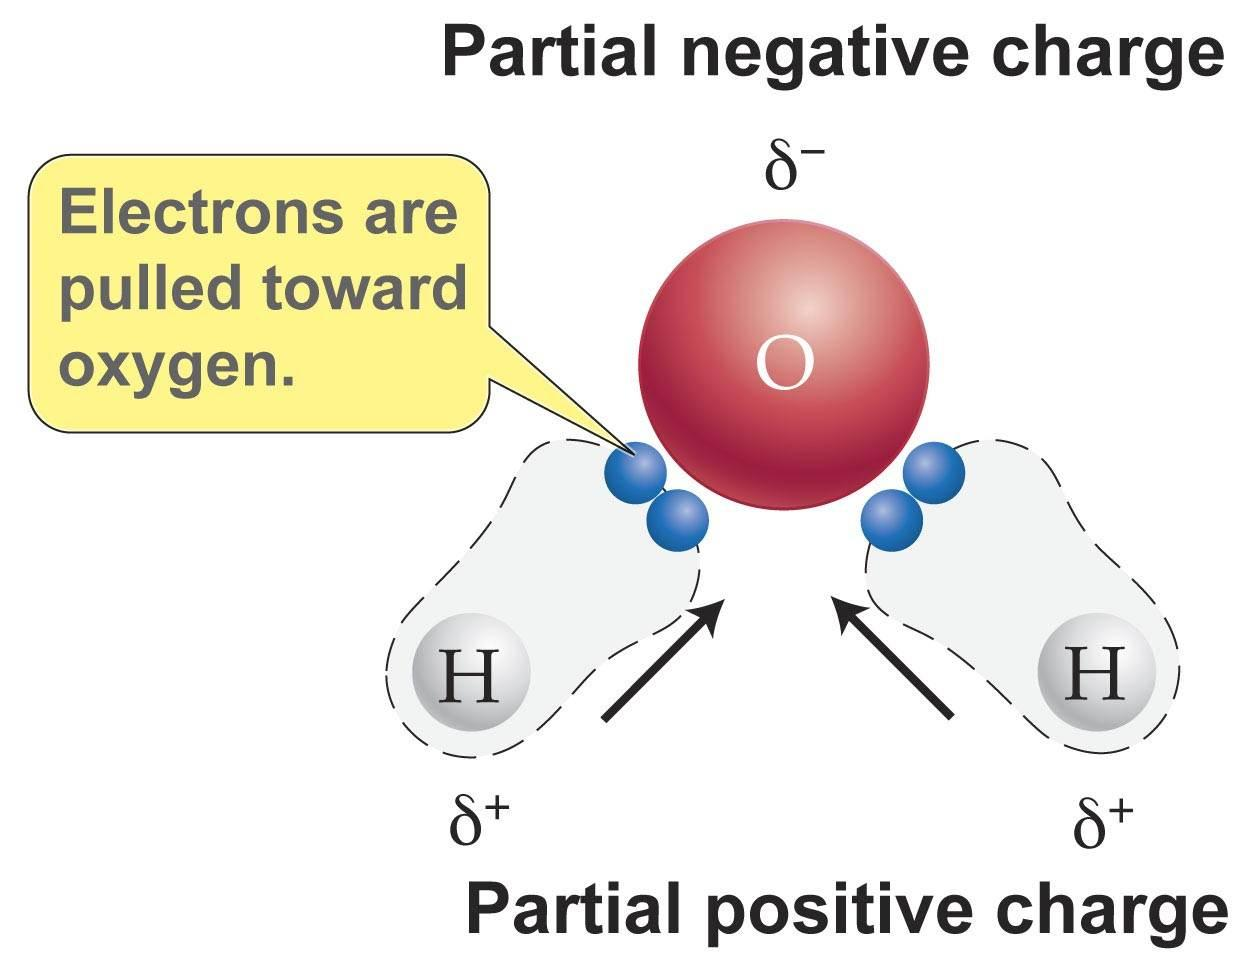

As a result of water’s polarity, each water molecule attracts other water molecules because of the opposite charges between them, forming hydrogen bonds.

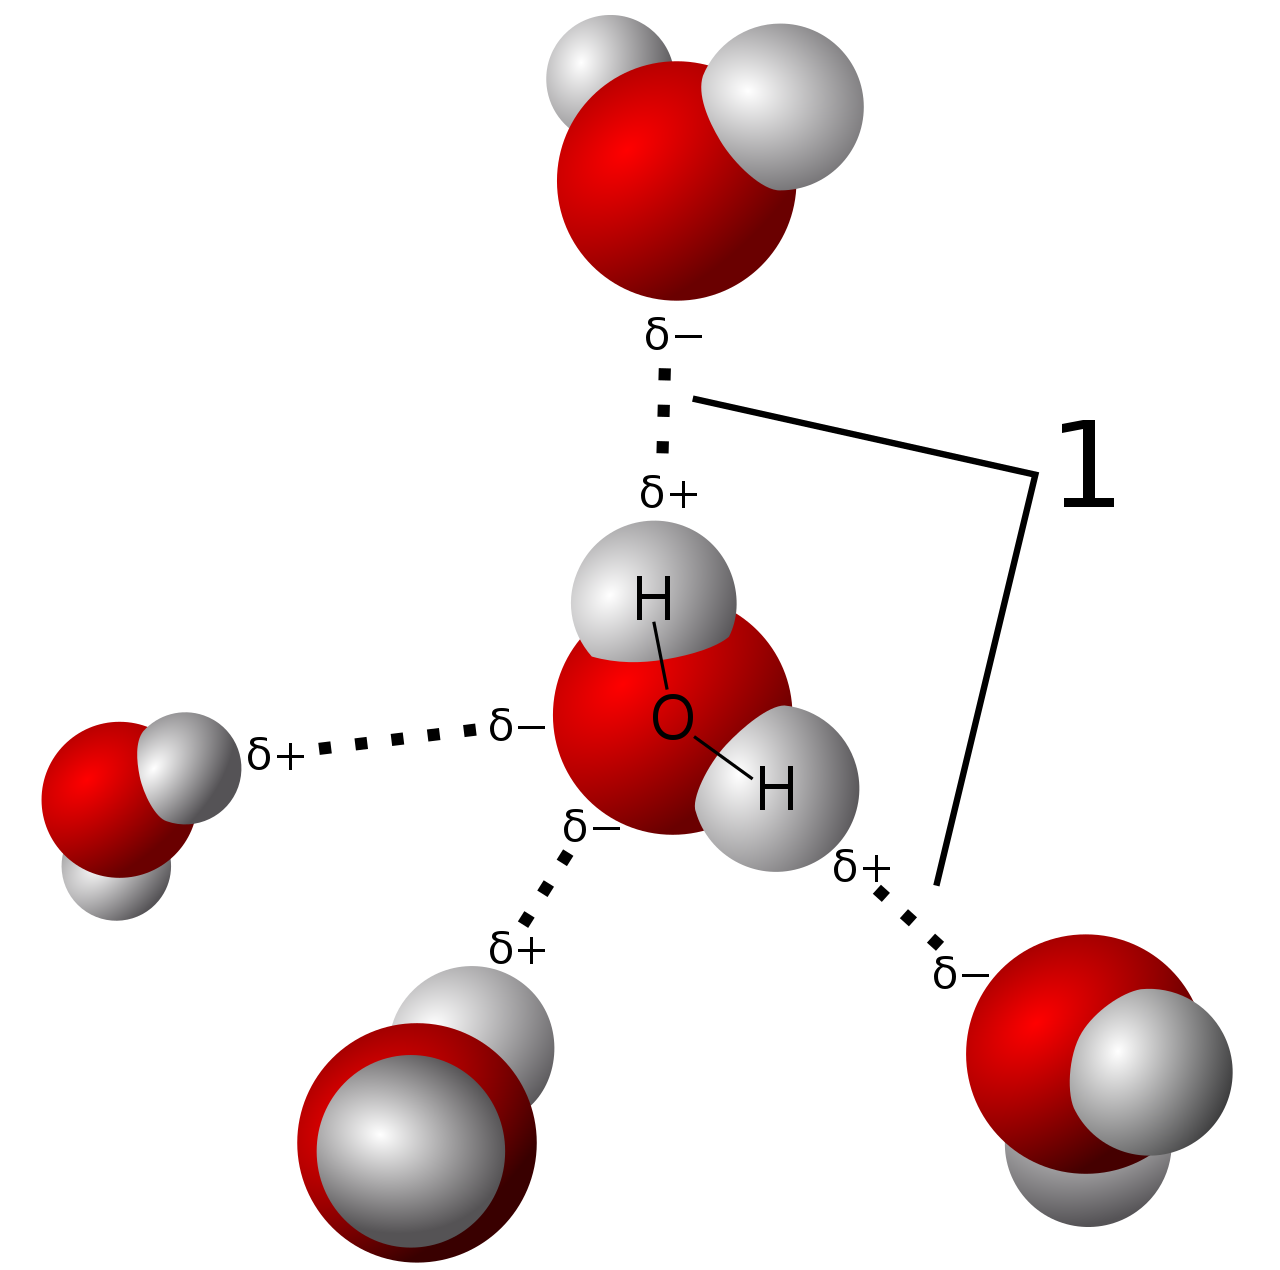

I started with the jupyter notebook "Polar Diatomic Molecules" and I've chosen to answer the question: "How would you modify this program to simulate water, instead of HCl?"

To simulate the movement of water molecules I started with the hydrogen chloride simulation, replaced the chloride by an oxygen and added an extra hydrogen molecule. I also expanded the simulation to three dimensions and made an animation.

## Setting up simulation

In [1]:
import numpy as np 
import time #to measure time
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0) #sets the seed for the simulation

We will model the polar molecules as an electric dipole, essentially a negative charge bound to two positve charges. We create a function that generates the starting positions of the H2O molecules in a square grid, while each molecule is rotated at some random angle (by choosing the x, y and z value for the oxygen atoms from a normal distribution). The three atoms that make up each molecule are initialized in their equilibrium positions, one 'bond_length' away from each other.

In [2]:
def make_liquid(num_molecules, dims, bond_length, bond_angle, grid_dims, side_lengths):
    #pos lets one atom spawn a bond_length away from the other atom, in a uniformly distributed random direction
    pos = np.random.normal(0,1,size=(num_molecules,dims)) #create an array to hold the x and y values of the hydrogen atom positions, relative to the molecule's location
    r = np.linalg.norm(pos, axis = 1) #determine the length of the random spacing between the atoms
    pos = pos/r.reshape(num_molecules,1)*bond_length #scale the positions by the random spacing length to normalize
    """Note: reshape allows the array of shape (num_molecules, dims) to be
    divided by an array (tuple) with shape (num_molecules, )
    by giving it shape (num_molecules, 1), both the x and y component will then be divided by r. """
    print(pos.shape)
    
    molecule = np.zeros((num_molecules, dims)) #array to hold the positions of the different atoms
    
    #initialize the molecules in a square grid, with random rotation
    xx = np.linspace(-side_lengths[0]/2, side_lengths[0]/2, grid_dims[0]) #x dimension for meshgrid
    yy = np.linspace(-side_lengths[1]/2, side_lengths[1]/2, grid_dims[1]) #y dimension for meshgrid
    zz = np.linspace(-side_lengths[2]/2, side_lengths[2]/2, grid_dims[2]) #z dimension for meshgrid
    mesh_x, mesh_y, mesh_z = np.meshgrid(xx,yy,zz) #creates three meshgrids 
    
    #ravel flattens the 3d array into a 1d array
    molecule[:,0] = np.ravel(mesh_x) # Sets the x-position 
    molecule[:,1] = np.ravel(mesh_y) # Sets the y-position
    molecule[:,2] = np.ravel(mesh_z) # Sets the z-position
    # The centre of the molecules will be in a grid formation
    
    def z_rotation(vector,theta):
        """Rotates 3-D vector around z-axis"""
        R = np.array([[np.cos(theta), -np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])
        pos2 = vector
        for i in range(num_molecules):
            pos2[i] = np.dot(R,pos2[i,:])
        return pos2

    H1 = molecule + pos 
    H2 = molecule + z_rotation(pos, bond_angle)
    O = molecule
    
    return H1, H2, O

H2O molecule now looks like H-O-H. Have added the angle between the two hydrogen molecules by rotating the second hydrogen molecule around the z-axis.

We also need to define some constants for the model, including the atomic mass unit (u), elementary electric charge (e), vacuum permittivity, Coulomb constant, and the Boltzmann Constant

In [3]:
u = 1.66053906660e-27 #atomic mass unit
e_charge =  1.602176634e-19 # Elementary charge (1 eV)
vac_perm = 8.8541878128e-12 #s^2*C^2*/m^3/kg
k_e = 1/(4*np.pi*vac_perm) # m^3*kg/s^2/C^2 Coulomb constant
k_boltz = 1.380649e-23 #Boltzmann constant

Next, we define some simulation parameters: the grid dimensions, the corresponding number of molecules in the simulation, and the number/length of the timesteps in the simulation.

In [4]:
# Simulation parameters
grid_dims = np.array([2,2,2]) # Determines the number of molecules in the simulation (x*y)
num_molecules = np.prod(grid_dims) #explicitly determine number of molecules in the simulation, here set to fill the grid
timesteps = 1000 #Number of timesteps to simulate
dt = 5e-17 #[s] Extremely low timestep

Parameters for simulating H2O
Now we need to define some more specific parameters, that will allow us to simulate a specific water system. These include the number of atoms in a single molecule, the number of spatial dimensions, and the parameters for the specific type of molecule we're dealing with (H2O in this example).

In [5]:
num_atoms = 3 #number of atoms in one molecule
dims = 3 #number of spatial dimensions 
# (the rest of the code is not written to handle anything but two dimensions, though you could change that)

partial_charge = 0.7*e_charge # The partial charges for oxygen in H2O
# https://chem.libretexts.org/Courses/Mount_Royal_University/Chem_1201/Unit_3%3A_Chemical_Bonding_I_-_Lewis_Theory/3.4%3A_Bond_Polarity
charge_H = 0.5*partial_charge # Effective charge of the hydrogen
charge_O = -partial_charge # Effective charge of the oxygen
# Oxygen is more electronegative than hydrogen, so the electron is, on average, closer to the oxygen

mass_H = 1.00794*u # Mass of hydrogen
mass_O= 15.999*u # Mass of oxygen
#http://www.chemicalelements.com/elements

# bond angle of H-O-H

bond_angle = 104.5*np.pi/180 # radians

bond_length = 9.7e-11 #[m] the distance between H and O in H2O
# http://hyperphysics.phy-astr.gsu.edu/hbase/molecule/vibrot.html#c3
side_lengths = [2*grid_dims[0]*bond_length, 2*grid_dims[1]*bond_length, 2*grid_dims[2]*bond_length]
# Determines the spacing of the molecules in x and y direction
k_spring = 458.9 # bond strength of H2O
#http://hyperphysics.phy-astr.gsu.edu/hbase/molecule/vibrot.html#c2

Finally, we need to make some numpy arrays, so we can fill and use them later. These will be useful for both graphing and speeding up calculations. Then, we call the make_liquid function to create the simulation.

In [6]:
# Initialize numpy arrays
position_H1 = np.zeros((timesteps, num_molecules, dims))
position_H2 = np.zeros((timesteps, num_molecules, dims))
position_O = np.zeros((timesteps, num_molecules, dims))
matrix_shape = position_H1.shape 
# The other arrays (vel, acc, etc.) should be the same shape as the position arrays
velocity_H1 = np.zeros(matrix_shape) # Velocity
velocity_H2 = np.zeros(matrix_shape) # Velocity
velocity_O = np.zeros(matrix_shape) # Velocity
acceleration_H1 = np.zeros(matrix_shape) # Acceleration
acceleration_H2 = np.zeros(matrix_shape) # Acceleration
acceleration_O = np.zeros(matrix_shape) # Acceleration
coulomb_acc_H1 = np.zeros(matrix_shape) # Intermolecular coulomb interaction
coulomb_acc_H2 = np.zeros(matrix_shape) # Intermolecular coulomb interaction
coulomb_acc_O = np.zeros(matrix_shape) # Intermolecular coulomb interaction
spring_acc_H1 = np.zeros(matrix_shape) # Intramolecular interaction
spring_acc_H2 = np.zeros(matrix_shape) # Intramolecular interaction
spring_acc_O = np.zeros(matrix_shape) # Intramolecular interaction

# Set the initial position for all the atoms
position_H1[0], position_H2[0], position_O[0] = make_liquid(num_molecules, dims, bond_length, bond_angle, grid_dims, side_lengths)

(8, 3)


## Forces and integration loop

To model the bonding between to atoms, to create a molecule, a harmonic oscillator potential is used. The force is then simply calculated usig Hooke's law with the appropriate constants, found in (http://hyperphysics.phy-astr.gsu.edu/hbase/molecule/vibrot.html). This force is given by
$$
    F(x) = k(x-x_0),
$$
where $k = k\_spring$ is the spring constant, $x = spring\_distance$ is the distance between the two relevant atoms, and $x_0 = bond\_length$ is the equilibrium distance for H2O. 

The second force, which to us is the most interesting, is Coulomb force. We get Coulomb forces between H2O molecules because the hydrogen and the oxygen have opposite partial charges. The forces, between atoms in different molecules, are then given by
$$
    F(x) = k_e\frac{q_Hq_{O}}{x^2},
$$
where $k_e$ is the Coulomb constant, while $q_H = +\delta$ and $q_{Cl} = -\delta$ are the charges of the two atoms, where $\delta = 0.7 e$ is the partial charge. 

To integrate these forces we use the familiar Euler-Chromer method. 

In [7]:
timeit_start = time.time()
for t in range(timesteps-1):
    #-----------------------------------------------
    # Spring potential to simulate atom interactions in a molecule, the bond force, using for loops
    # This potential is a good approximations only when the atoms are close to the equilibrium, 
    # it does not allow the bondings to "break"
    for i in range(num_molecules):
        spring_difference1 = position_O[t,i] - position_H1[t,i]
        spring_difference2 = position_O[t,i] - position_H2[t,i]
        # position of one atom minus the position of the other,
        # gives the vector from H to Cl
        spring_distance1 = np.linalg.norm(spring_difference1)
        spring_distance2 = np.linalg.norm(spring_difference2)
        # Distance between the bound atoms
        spring_unitvector1 = spring_difference1/spring_distance1
        spring_unitvector2 = spring_difference2/spring_distance2
        # Unit vector pointing from H to Cl (from Cl to H would then be its negative)
        spring_force1 = k_spring*(spring_distance1 - bond_length) 
        spring_force2 = k_spring*(spring_distance2 - bond_length) 
        # Hooke's law, spring constant*distance from equilibrium
        spring_acc_H1[t,i] = spring_unitvector1*spring_force1/mass_H #direction*force/mass
        spring_acc_H2[t,i] = spring_unitvector2*spring_force2/mass_H #direction*force/mass
        spring_acc_O[t,i] = -spring_unitvector1*spring_force1/mass_O - spring_unitvector2*spring_force2/mass_O#direction*force/mass

    #-----------------------------------------------
    # Coulomb force between molecules
    for i in range(num_molecules):#num_molecules):
        coulomb_mask = np.arange(0,num_molecules)!=i #a mask to ignore atoms in the same molecule (same index)
        # Helps us in somewhat vectorizing the calculation
        
        coulomb_difference_H1_H1 = position_H1[t,i] - position_H1[t,coulomb_mask]
        coulomb_difference_H2_H2 = position_H2[t,i] - position_H2[t,coulomb_mask]
        coulomb_difference_H1_H2 = position_H1[t,i] - position_H2[t,coulomb_mask]
        coulomb_difference_H2_H1 = position_H2[t,i] - position_H1[t,coulomb_mask]
        #x, y, z difference between the hydrogen and other all other hydrogen atoms
        coulomb_difference_H1_O = position_H1[t,i] - position_O[t,coulomb_mask]
        coulomb_difference_H2_O = position_H2[t,i] - position_O[t,coulomb_mask]
        #x, y, z difference between the hydrogen and all chlorine atoms in other molecules
        coulomb_difference_O_H1 = position_O[t,i] - position_H1[t,coulomb_mask] 
        coulomb_difference_O_H2 = position_O[t,i] - position_H2[t,coulomb_mask] 
        #x, y, z difference between the chlorine and all hydrogen atoms in other molecules
        coulomb_difference_O_O = position_O[t,i] - position_O[t,coulomb_mask]
        #x, y, z difference between the hydrogen and other all other hydrogen atoms
        
        # Calculates the distance from one atom to num_molecules-1 other atoms
        coulomb_distance_H1_H1 = np.linalg.norm(coulomb_difference_H1_H1, axis = 1) # The distances between the atoms
        coulomb_distance_H2_H2 = np.linalg.norm(coulomb_difference_H2_H2, axis = 1)
        coulomb_distance_H1_H2 = np.linalg.norm(coulomb_difference_H1_H2, axis = 1)
        coulomb_distance_H2_H1 = np.linalg.norm(coulomb_difference_H2_H1, axis = 1)
        coulomb_distance_H1_O = np.linalg.norm(coulomb_difference_H1_O, axis = 1)
        coulomb_distance_H2_O = np.linalg.norm(coulomb_difference_H2_O, axis = 1)
        coulomb_distance_O_H1 = np.linalg.norm(coulomb_difference_O_H1, axis = 1)
        coulomb_distance_O_H2 = np.linalg.norm(coulomb_difference_O_H2, axis = 1)
        coulomb_distance_O_O = np.linalg.norm(coulomb_difference_O_O, axis = 1)
        
        # Reshape distance from (num_molecules-1,) to (num_molecules-1, 1)
        # This gives us num_molecules-1 unit vectors from one atom to num_molecules-1 others
        coulomb_unitvector_H1_H1 = coulomb_difference_H1_H1/coulomb_distance_H1_H1.reshape(-1,1)
        coulomb_unitvector_H2_H2 = coulomb_difference_H2_H2/coulomb_distance_H2_H2.reshape(-1,1)
        coulomb_unitvector_H1_H2 = coulomb_difference_H1_H2/coulomb_distance_H1_H2.reshape(-1,1)
        coulomb_unitvector_H2_H1 = coulomb_difference_H2_H1/coulomb_distance_H2_H1.reshape(-1,1)
        coulomb_unitvector_H1_O = coulomb_difference_H1_O/coulomb_distance_H1_O.reshape(-1,1)
        coulomb_unitvector_H2_O = coulomb_difference_H2_O/coulomb_distance_H2_O.reshape(-1,1)
        coulomb_unitvector_O_H1 = coulomb_difference_O_H1/coulomb_distance_O_H1.reshape(-1,1)
        coulomb_unitvector_O_H2 = coulomb_difference_O_H2/coulomb_distance_O_H2.reshape(-1,1)
        coulomb_unitvector_O_O = coulomb_difference_O_O/coulomb_distance_O_O.reshape(-1,1)
        
        # Calculate the force according to Coulomb's law
        coulomb_force_H1_H1 = k_e*charge_H*charge_H*coulomb_unitvector_H1_H1/coulomb_distance_H1_H1.reshape(-1,1)**2
        coulomb_force_H2_H2 = k_e*charge_H*charge_H*coulomb_unitvector_H2_H2/coulomb_distance_H2_H2.reshape(-1,1)**2
        coulomb_force_H1_H2 = k_e*charge_H*charge_H*coulomb_unitvector_H1_H2/coulomb_distance_H1_H2.reshape(-1,1)**2
        coulomb_force_H2_H1 = k_e*charge_H*charge_H*coulomb_unitvector_H2_H1/coulomb_distance_H2_H1.reshape(-1,1)**2
        coulomb_force_H1_O = k_e*charge_H*charge_O*coulomb_unitvector_H1_O/coulomb_distance_H1_O.reshape(-1,1)**2
        coulomb_force_H2_O = k_e*charge_H*charge_O*coulomb_unitvector_H2_O/coulomb_distance_H2_O.reshape(-1,1)**2
        coulomb_force_O_H1 = k_e*charge_O*charge_H*coulomb_unitvector_O_H1/coulomb_distance_O_H1.reshape(-1,1)**2
        coulomb_force_O_H2 = k_e*charge_O*charge_H*coulomb_unitvector_O_H2/coulomb_distance_O_H2.reshape(-1,1)**2
        coulomb_force_O_O = k_e*charge_O*charge_O*coulomb_unitvector_O_O/coulomb_distance_O_O.reshape(-1,1)**2
        
        # Sum together the forces from the different molecules acting upon atom i, and divide by mass to get acc
        coulomb_acc_H1[t,i] = (np.sum(coulomb_force_H1_H1, axis = 0)\
                               + np.sum(coulomb_force_H1_O, axis = 0) + np.sum(coulomb_force_H1_H2, axis = 0))/mass_H
        coulomb_acc_H2[t,i] = (np.sum(coulomb_force_H2_H2, axis = 0)\
                               + np.sum(coulomb_force_H2_O, axis = 0) + np.sum(coulomb_force_H2_H1, axis = 0))/mass_H
        coulomb_acc_O[t,i] = (np.sum(coulomb_force_O_H1, axis = 0)\
                              + np.sum(coulomb_force_O_H2, axis = 0) + np.sum(coulomb_force_O_O, axis = 0))/mass_O
        
    #----------------------------------------------
    # Sum the accelerations
    
    acceleration_H1[t] = coulomb_acc_H1[t] + spring_acc_H1[t]
    acceleration_H2[t] = coulomb_acc_H2[t] + spring_acc_H2[t]
    acceleration_O[t] = coulomb_acc_O[t] + spring_acc_O[t]
    
    # Euler Chromer
    velocity_H1[t+1] = velocity_H1[t] + acceleration_H1[t]*dt
    velocity_H2[t+1] = velocity_H2[t] + acceleration_H2[t]*dt
    velocity_O[t+1] = velocity_O[t] + acceleration_O[t]*dt
    position_H1[t+1] = position_H1[t] + velocity_H1[t+1]*dt
    position_H2[t+1] = position_H2[t] + velocity_H2[t+1]*dt
    position_O[t+1] = position_O[t] + velocity_O[t+1]*dt
    
    if t!=0 and t%int(timesteps/20) == 0: # Every long for-loop needs some kind of "loading bar"
        print(t, 'of', timesteps)
timeit_stop = time.time()
print('It took %.1f seconds to simulate %i molecules for %i timesteps' \
      %(timeit_stop-timeit_start, num_molecules, timesteps))

50 of 1000
100 of 1000
150 of 1000
200 of 1000
250 of 1000
300 of 1000
350 of 1000
400 of 1000
450 of 1000
500 of 1000
550 of 1000
600 of 1000
650 of 1000
700 of 1000
750 of 1000
800 of 1000
850 of 1000
900 of 1000
950 of 1000
It took 8.7 seconds to simulate 8 molecules for 1000 timesteps


I've used mpl toolkit to make 3D plots of the molecules.

<IPython.core.display.Javascript object>


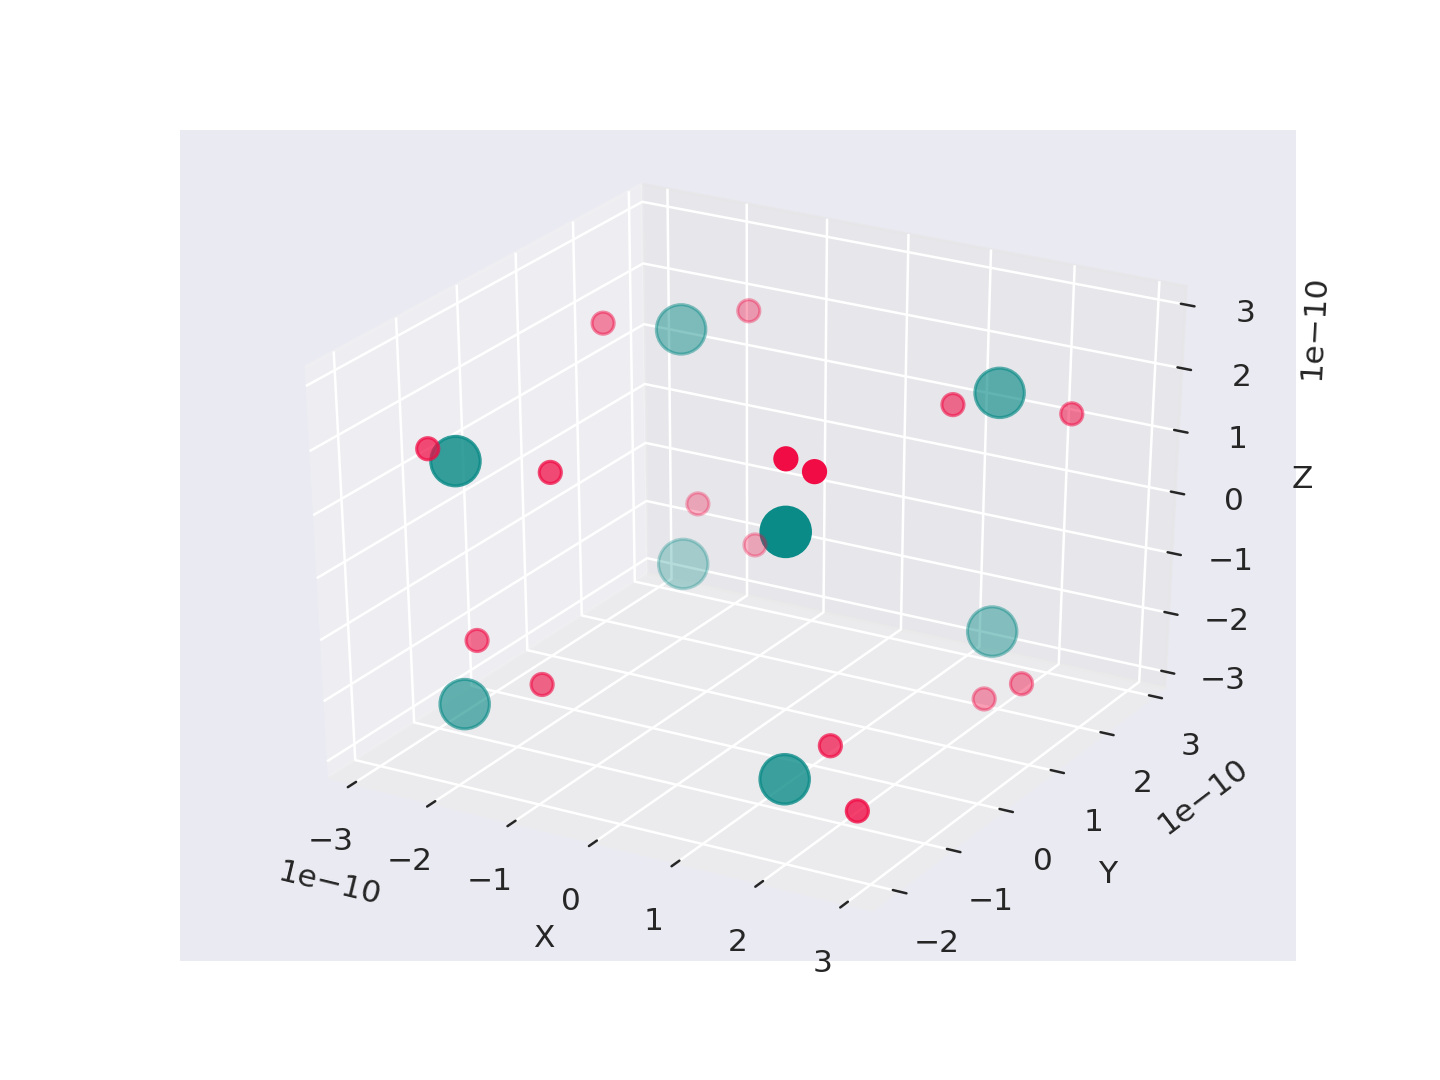

<IPython.core.display.Javascript object>


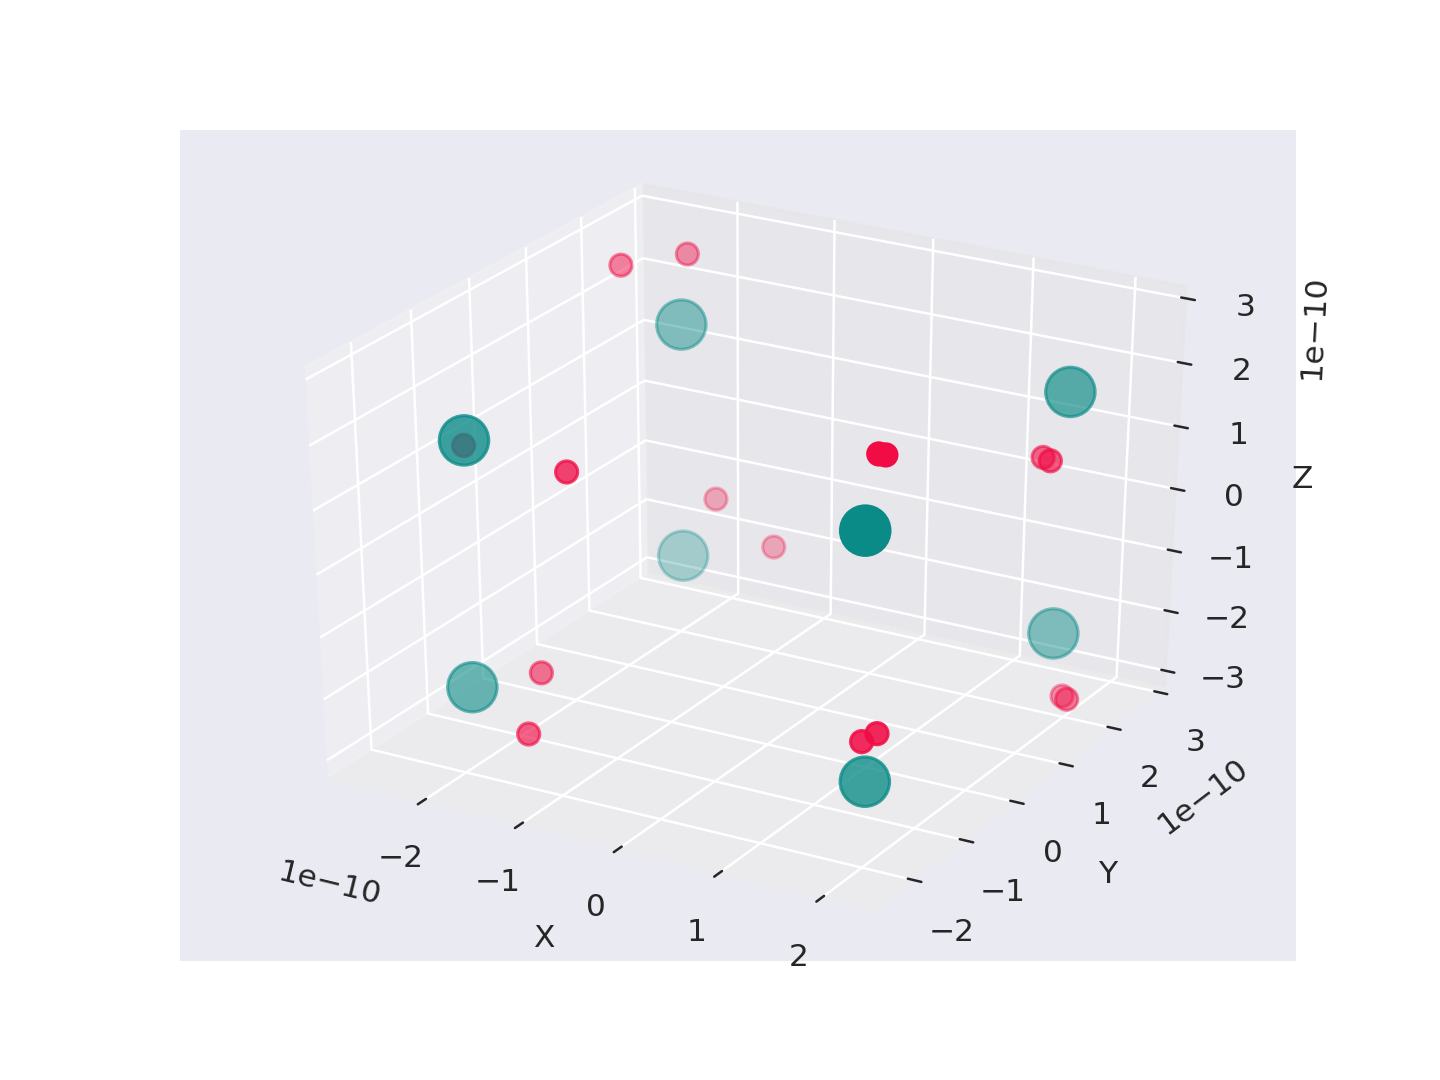

In [8]:
plt.rcParams['figure.figsize'] = [8, 5]
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial positions
ax.scatter(position_H1[0,:,0], position_H1[0,:,1],  position_H1[0,:,2], c='xkcd:pinkish red', marker='o', s=50)
ax.scatter(position_H2[0,:,0], position_H2[0,:,1],  position_H2[0,:,2], c='xkcd:pinkish red', marker='o', s=50)
ax.scatter(position_O[0,:,0], position_O[0,:,1],  position_O[0,:,2], c='xkcd:greenish blue', marker='o', s=250)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# Final positions after N timesteps
ax2.scatter(position_H1[-1,:,0], position_H1[-1,:,1],  position_H1[-1,:,2], c='xkcd:pinkish red', marker='o', s=50)
ax2.scatter(position_H2[-1,:,0], position_H2[-1,:,1],  position_H2[-1,:,2], c='xkcd:pinkish red', marker='o', s=50)
ax2.scatter(position_O[-1,:,0], position_O[-1,:,1],  position_O[-1,:,2], c='xkcd:greenish blue', marker='o', s=250)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

The animation is made using matplotlib's animations library. For some reason the animation will not play in jupyter notebook, and has to be opened in another viewer.

<IPython.core.display.Javascript object>


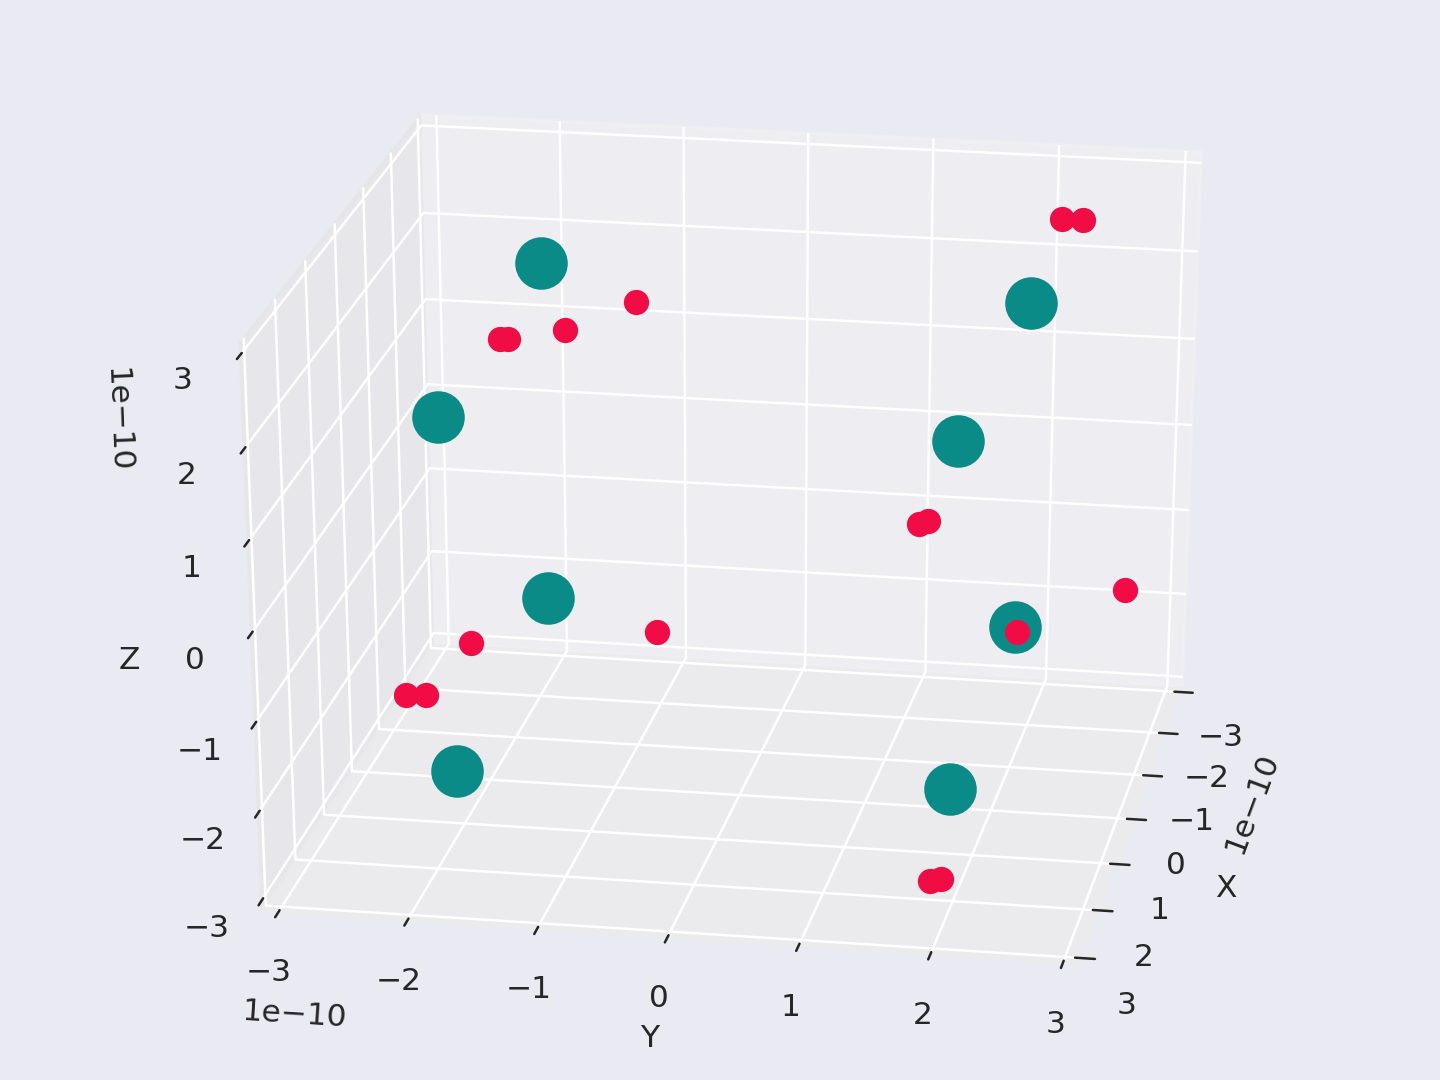

In [9]:
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3

def animate_scatters(iteration, data, scatters1, scatters2, scatters3):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    data1, data2, data3 = data
    for i in range(data1[0].shape[0]):
        scatters1[i]._offsets3d = (data1[iteration][i,0:1], data1[iteration][i,1:2], data1[iteration][i,2:])
        scatters2[i]._offsets3d = (data2[iteration][i,0:1], data2[iteration][i,1:2], data2[iteration][i,2:])
        scatters3[i]._offsets3d = (data3[iteration][i,0:1], data3[iteration][i,1:2], data3[iteration][i,2:])
    return scatters1, scatters2, scatters3

def main(data, save=False):
    """
    Creates the 3D figure and animates it with the input data.
    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """

    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    
    
    # Initialize scatters
    data1 = data[0]
    scatters1 = [ ax.scatter(data1[0][i,0:1], data1[0][i,1:2], data1[0][i,2:],c='xkcd:pinkish red', s = 50) for i in range(data1[0].shape[0]) ]
    data2 = data[1]
    scatters2 = [ ax.scatter(data2[0][i,0:1], data2[0][i,1:2], data2[0][i,2:],c='xkcd:pinkish red', s = 50) for i in range(data2[0].shape[0]) ]
    data3 = data[2]
    scatters3 = [ ax.scatter(data3[0][i,0:1], data3[0][i,1:2], data3[0][i,2:],c='xkcd:greenish blue', s=250) for i in range(data3[0].shape[0]) ]
    
    # Number of iterations
    iterations = len(data1)

    # Setting the axes properties
    ax.set_xlim3d([-3*10**(-10), 3*10**(-10)])
    ax.set_xlabel('X')

    ax.set_ylim3d([-3*10**(-10), 3*10**(-10)])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-3*10**(-10), 3*10**(-10)])
    ax.set_zlabel('Z')

    # Provide starting angle for the view.
    ax.view_init(25, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters1, scatters2, scatters3),
                                       interval=5, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=200, metadata=dict(artist='Me'), bitrate=-1, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-scatted-animated.mp4', writer=writer)

    plt.show()

data = [position_H1, position_H2, position_O]
main(data, save=True)

## Discussion and Conclusion

The change from HCl to H2O, expansion from two to three dimensions and the animation was successful. However there are multiple improvements that can be made. We could have taken into account the temperature and pressure dependence of the molecules' movement. Because of lack of computer power I was only able to simulate a low number of molecules, it would be intresting to see how the molecules would behave if there were more of them. That would be a more realistic model. 

There is something strange happening in the animation when the molecules get to close, some of them are thrown away, I don't know if this is realistic or if there is something wrong with the force model.

To improve to model further I would optimize the integration loop to speed it up, for example by using jit. Maybe it would also be possible to get rid of the nested for loop. I would also add lines between the atoms in the molecule to make it more obvious which atoms belong together. It would also be intresting to see what would happen if I added another molecule to the water, for example a protein or a salt. 

## References

https://en.wikipedia.org/wiki/Water#Polarity_and_hydrogen_bonding

https://medium.com/@pnpsegonne/animating-a-3d-scatterplot-with-matplotlib-ca4b676d4b55